In [5]:
# imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne
import pickle
import xarray as xr

# include code path
sys.path.append('utils')

# load custom shield scripts
from shield_utils import find_animals, get_lfp_dict, downsample, align_lfp, load_animals_oi

# paths
data_path = '/oscar/data/sjones/kduecker/shield_data'
meta_path = 'externals/SHIELD_Dynamic_Gating_Analysis'

subj_id = 2


down_srate = 500
roi = ['LGd', 'VISp']
toi = [0, .5]

mice_sess = load_animals_oi()

# loop over mice here and store

subj = list(mice_sess.keys())[0]

ses_files = os.listdir(os.path.join(data_path,f'sub-{subj}'))

# get lfp files and spike files
lfp_files = list(filter(lambda s: 'None' in s, ses_files))

session = mice_sess[subj][0]
ses_file = list(filter(lambda s: session in s, ses_files))


with open(os.path.join(data_path,'results_lfp_layer', f'lfp_{subj}_{session}.pkl'), 'rb') as f:
    lfp = pickle.load(f)

In [104]:
# concatenate probes recording from same structure into 3d arrays
probe_names = sorted(lfp['LGd'].keys())

# Expand each DataArray to include the "probe" dimension and assign coordinates
arrays = [
    lfp['LGd'][name].expand_dims('probe').assign_coords(probe=[name])
    for name in probe_names
]

# concatenate data from the different channels or expand if there is only one probe
lfp3d = xr.concat(arrays, dim='probe')
lfp3d = lfp3d.sel(time=(lfp3d.time > toi[0]) & (lfp3d.time <= toi[1]))

FS_LFP = 500 
if lfp3d.time[-1] < 1:
    pad_length = int((FS_LFP-len(lfp3d.time))/2)
    timevec = np.linspace(lfp3d.time[0]-(1/FS_LFP)*pad_length, lfp3d.time[-1]+(1/FS_LFP)*pad_length, len(lfp3d.time)+pad_length*2)
    lfp3d = lfp3d.pad(time=(pad_length,pad_length), constant_values=0)
    lfp3d['time'] = timevec

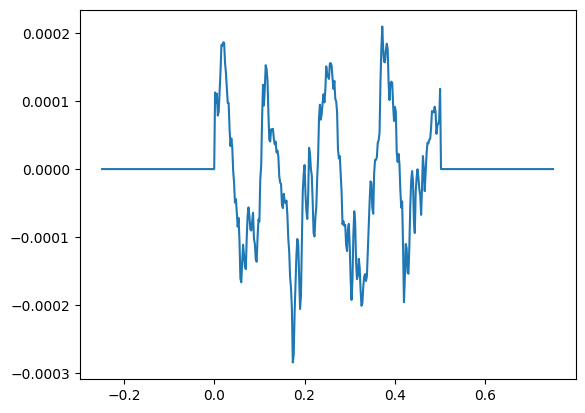

In [106]:
plt.plot(lfp3d.time, lfp3d.data[0][0,:])

In [32]:
unique_structures = ['LGd', 'VISp']

structure = unique_structures[1]
# concatenate probes recording from same structure into 3d arrays
probe_names = sorted(lfp[structure].keys())

# Expand each DataArray to include the "probe" dimension and assign coordinates
arrays = [
    lfp[structure][name].expand_dims('probe').assign_coords(probe=[name])
    for name in probe_names
]

# concatenate data from the different channels or expand if there is only one probe
lfp3d = xr.concat(arrays, dim='probe')

lfp3d.sel(time=(lfp3d.time > 0) & (lfp3d.time <1))


<xarray.DataArray (probe: 2, presentation_id: 150, time: 499)> Size: 1MB
array([[[-3.18649446e-05, -5.47950844e-05, -7.48906137e-05, ...,
         -1.22329873e-04, -1.36899564e-04, -1.30870097e-04],
        [-4.24560316e-05, -4.66454128e-05, -4.88371949e-05, ...,
          7.00250749e-05,  5.55587559e-05,  4.82254618e-05],
        [-5.77565126e-05, -3.95335060e-05, -5.47978762e-05, ...,
          3.03034741e-05,  4.67605105e-05,  2.96097125e-05],
        ...,
        [-1.39787510e-04, -8.74597102e-05, -6.33483377e-05, ...,
         -2.30545801e-05, -3.09397446e-05, -2.70072260e-05],
        [ 1.40886365e-05,  3.85006009e-05,  7.46775211e-05, ...,
          4.37840107e-05,  3.13790260e-05, -1.58763370e-05],
        [ 1.53439363e-05, -1.10983225e-05, -1.62243396e-05, ...,
          9.75068992e-05,  1.04986680e-04,  1.13026007e-04]],

       [[-3.49613510e-05, -2.59017498e-05, -4.43094816e-05, ...,
         -3.72617674e-05, -5.40888003e-05, -5.98780590e-05],
        [ 6.25083525e-05,  4.45584264e-05,  3.34382254e-05, ...,
          9.65935020e-07,  7.01816279e-06, -7.37461342e-06],
        [ 4.78880169e-05,  8.41202276e-05,  8.94420239e-05, ...,
          2.94419836e-05,  2.73418529e-05,  2.73677143e-05],
        ...,
        [-5.99056574e-05, -2.07949345e-05,  6.30613067e-06, ...,
          1.54816617e-05, -4.94041951e-06,  1.21678029e-06],
        [-2.02008103e-05, -2.99863366e-05, -5.25779620e-05, ...,
          5.57157177e-06, -9.52274940e-06, -3.03350203e-05],
        [-2.16753219e-05, -3.12856712e-05, -2.39457027e-05, ...,
         -1.06084758e-05,  1.11331443e-05,  2.13061840e-05]]])
Coordinates:
    trial    (presentation_id) int64 1kB 8845 8846 8847 8848 ... 8992 8993 8994
  * time     (time) float64 4kB 0.002 0.004 0.006 0.008 ... 0.994 0.996 0.998
  * probe    (probe) <U7 56B 'probe 7' 'probe 8'
Dimensions without coordinates: presentation_id

In [16]:
FS_LFP = 500 # downsampled frequency for LFP
# spectrogram hyperparameters
FREQS = [2, 100, 98] # [start, stop, n_freqs] (Hz)
N_CYCLES = 5 # for Morlet decomp
specparam_min_freq = 2
specparam_max_freq = 100

# SpecParam hyperparameters
SPECPARAM_SETTINGS = {
    'peak_width_limits' :   [0.1, 12.0], #[2, 20], # default : (0.5, 12.0) - recommends at least frequency resolution * 2
    'min_peak_height'   :   0, # default : 0
    'max_n_peaks'       :   10, # default : inf
    'peak_threshold'    :   1., # default : 2.0
    # 'aperiodic_mode'    :   'knee'
    'aperiodic_mode'    :   'fixed'
    } # 'fixed' or 'knee'
N_JOBS = 20

In [17]:
from tfr_utils import compute_tfr

tfr, tfr_freqs = compute_tfr(lfp3d.data, FS_LFP, FREQS, method='stockwell', 
                                                n_morlet_cycle=N_CYCLES, n_jobs=N_JOBS)

Text(0, 0.5, 'frequency (Hz)')

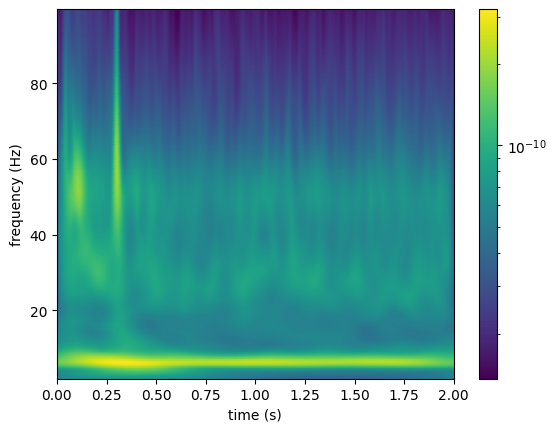

In [18]:
figure_dir_name = f'figures/specparam_plots/{subj}_{session}_{structure}/'
os.makedirs(figure_dir_name, exist_ok=True)
plt.pcolormesh(arrays[0].time, tfr_freqs, tfr.mean(axis=0),norm='log', shading='gouraud', rasterized=True)
plt.colorbar()
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')



In [ ]:
sf = session_file[0]

# load session
nwb_file_asset = pynwb.NWBHDF5IO(f'{data_path}/sub-{subj}/{sf}', mode='r', load_namespaces=True)
nwb_file = nwb_file_asset.read()
dynamic_gating_session = DynamicGatingEcephysSession.from_nwb(nwb_file)

# get stimulus presentations
stim_presentations = dynamic_gating_session.stimulus_presentations
flashes = stim_presentations[stim_presentations['stimulus_name'].str.contains('flash')]
presentation_times = flashes.start_time.values
flash_end_times = presentation_times + flashes.duration
presentation_ids = flashes.index.values

In [ ]:
tfr_lfp, freq = compute_tfr(lfp3d.data, 500, freqs, freq_spacing='lin', output='power', method='stockwell', verbose=False)

In [ ]:
lfp3d.data.shape

In [ ]:
# TFR 
from tfr_utils import compute_tfr, plot_tfr
freqs = (2, 60, 58)

tfr_lfp, freq = compute_tfr(lfp3d.data, 500, freqs, freq_spacing='lin', output='power', method='stockwell', verbose=False)
spec = tfr_lfp.mean(axis=-1)

tfr_lfp_probe1, freq = compute_tfr(np.expand_dims(lfp3d.data[0],0), 500, freqs, freq_spacing='lin', output='power', method='stockwell', verbose=False)
spec_probe1 = tfr_lfp_probe1.mean(axis=-1)

tfr_lfp_probe2, freq = compute_tfr(np.expand_dims(lfp3d.data[1],0), 500, freqs, freq_spacing='lin', output='power', method='stockwell', verbose=False)
spec_probe2 = tfr_lfp.mean(axis=-1)

In [ ]:
freqs = (2, 60, 58)

fig, ax = plt.subplots(3,4, figsize=(16,8))

tfr_lfp, freq = compute_tfr(lfp3d.data, 500, freqs, freq_spacing='lin', output='power', method='stockwell', verbose=False)
time = np.linspace(0,2,tfr_lfp.shape[-1])

ax[0,0].pcolor(time,freq,  tfr_lfp[0], shading='nearest')
ax[0,0].set_title('average both probes single trial')
ax[0,1].plot(freq, tfr_lfp[0].mean(axis=1))
ax[0,2].pcolor(time,freq,  np.mean(tfr_lfp, axis=0), shading='nearest')
ax[0,2].set_title('average both probes average over trials')
ax[0,3].plot(freq, np.mean(spec, axis=0))
ax[0,3].fill_between(freq, np.mean(spec, axis=0)-np.std(spec, axis=0), np.mean(spec, axis=0)+np.std(spec, axis=0), alpha=0.5)


ax[1,0].pcolor(time,freq,  tfr_lfp[0], shading='nearest')
ax[1,0].set_title('probe 1')
ax[1,1].plot(freq, tfr_lfp_probe1[0].mean(axis=1))
ax[1,2].pcolor(time,freq,  np.mean(tfr_lfp_probe1, axis=0), shading='nearest')
ax[1,2].set_title('probe 1')
ax[1,3].plot(freq, np.mean(spec_probe1, axis=0))
ax[1,3].fill_between(freq, np.mean(spec_probe1, axis=0)-np.std(spec_probe1, axis=0), np.mean(spec_probe1, axis=0)+np.std(spec_probe1, axis=0), alpha=0.5)

ax[2,0].pcolor(time,freq,  tfr_lfp_probe2[0], shading='nearest')
ax[2,0].set_title('probe 2')
ax[2,1].plot(freq, tfr_lfp[0].mean(axis=1))
ax[2,2].pcolor(time,freq,  np.mean(tfr_lfp_probe2, axis=0), shading='nearest')
ax[2,2].set_title('probe 2')
ax[2,3].plot(freq, np.mean(spec_probe2, axis=0))
ax[2,3].fill_between(freq, np.mean(spec_probe2, axis=0)-np.std(spec_probe2, axis=0), np.mean(spec_probe2, axis=0)+np.std(spec_probe2, axis=0), alpha=0.5)
fig.tight_layout()


In [ ]:
freq

In [ ]:
# Specparam
SPECPARAM_SETTINGS = {
        'peak_width_limits' :   [0.1, 12], # default : (0.5, 12.0) - recommends at least frequency resolution * 2
        'min_peak_height'   :   0, # default : 0
        'max_n_peaks'       :   10, # default : inf
        'peak_threshold'    :   1., # default : 2.0
        # 'aperiodic_mode'    :   'knee'
        'aperiodic_mode'    :   'fixed'
        }

specparam_min_freq = 2
specparam_max_freq = 60
freq_filter = np.logical_and(freq >= specparam_min_freq, freq <= specparam_max_freq)

from extract_all_features import apply_specparam, compute_flattened_spectra
sgm = apply_specparam(spec[None,:,freq_filter], freq[freq_filter], SPECPARAM_SETTINGS, 1)


In [ ]:
sgm.plot()

In [ ]:
res = sgm.get_model(0)
res.plot(plt_log=True, save_fig=False)

In [ ]:
exponent = sgm.get_params('aperiodic', 'exponent')

spectra_flat = compute_flattened_spectra(sgm)

In [ ]:
freqs_trials = [sgm.freqs for _ in range(len(spectra_flat))]
freqs_trials

In [ ]:
subj

In [ ]:
import pynwb
from allensdk.brain_observatory.ecephys.dynamic_gating_ecephys_session import DynamicGatingEcephysSession
# initialize LFP dictionary
layer_data = dict()

# load session

for sf in ses_file:
    nwb_file_asset = pynwb.NWBHDF5IO(f'{data_path}/sub-{subj}/{sf}', mode='r', load_namespaces=True)
    nwb_file = nwb_file_asset.read()
    dynamic_gating_session = DynamicGatingEcephysSession.from_nwb(nwb_file)

    # get stimulus presentations
    stim_presentations = dynamic_gating_session.stimulus_presentations
    flashes = stim_presentations[stim_presentations['stimulus_name'].str.contains('flash')]
    presentation_times = flashes.start_time.values
    flash_end_times = presentation_times + flashes.duration
    presentation_ids = flashes.index.values

    # get sampling rate
    srate = dynamic_gating_session.probes.sampling_rate.values[0]
    dt = 1/srate

    # get the channels
    sess_units = dynamic_gating_session.get_units()
    chans = dynamic_gating_session.get_channels()

    # probe map
    probe_index = dynamic_gating_session.probes.index
    probe_map = {}
    for p in probe_index:
        probe_name = dynamic_gating_session.probes.name[p]
        filename = list(filter(lambda s: '-'+str(p)+'_' in s, lfp_files))
        probe_map[probe_name] = os.path.join(os.path.join(data_path,f'sub-{subj}'),filename[0])

    # add the LFP data to the session object
    dynamic_gating_session = DynamicGatingEcephysSession.from_nwb(nwb_file, probe_data_path_map=probe_map)

    # we have pre-selected the animals based on ROI so we know this has ROI
for r in roi:
    layer_data[r] = dict()

    # load LFP for each probe
    for pi in probe_index:
        probe_lfp = dynamic_gating_session.get_lfp(pi)

        structs = chans.loc[probe_lfp.channel.values].structure_acronym.unique()
        
        if r in structs:    

            print(f'found chan for {r} on probe {pi}')

            probe_lfp = dynamic_gating_session.get_lfp(pi)

            # Get channels in the current probe as integers
            probe_channels = probe_lfp.channel.values.astype(int)

            # Filter channels that are both:
            # 1. In the current probe (probe_channels)
            # 2. Have the target structure acronym (r)

            mask = (
                chans.index.astype(int).isin(probe_channels) &  # Check channel is in probe
                (chans['structure_acronym'] == r)               # Check structure matches
            )

            valid_channels = chans[mask].index.astype(int)

            # Convert to numpy array and ensure alignment with xarray's channel values
            valid_channels_np = probe_lfp.channel.values[np.isin(probe_lfp.channel.values, valid_channels)]

            lfp_roi = probe_lfp.sel(channel=valid_channels_np)

            # align LFP to stimulus presentations
            aligned_lfp = align_lfp(lfp_roi, np.arange(toi[0], toi[1], dt), presentation_times, presentation_ids)

            # downsample
            if down_srate < aligned_lfp.data.shape[-1]-1/toi[1]:
                # Calculate the new number of time points after downsampling
                new_time_points = int(down_srate * toi[1] + 1)
                
                # Create a new array with the downsampled shape
                new_data = np.zeros((aligned_lfp.data.shape[0], aligned_lfp.data.shape[1], new_time_points))

                for i, channel_lfp in enumerate(aligned_lfp.data):

                    # Downsample the current channel
                    downsampled_channel = downsample(channel_lfp, srate, down_srate)
                    
                    # Assign the downsampled channel to the new array
                    new_data[i] = downsampled_channel

                # Replace the DataArray with the new downsampled data
                aligned_lfp = xr.DataArray(
                    data=new_data,
                    dims=['channel', 'presentation_id', 'time'],
                    coords={
                        'channel': aligned_lfp.coords['channel'],
                        'trial': aligned_lfp.coords['presentation_id'],
                        'time': np.linspace(0, toi[1], int(down_srate * toi[1] + 1))
                    },
                    attrs=aligned_lfp.attrs  # Preserve original attributes if needed
                    )

            layer_data[r][f'probe {str(pi)}'] = aligned_lfp.mean(dim='channel')



In [ ]:
layer_data.keys()

In [ ]:
ses_file